In [2]:
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

# CCI Correction Agent

In [91]:
class CCI_Agent:
    def __init__(self, data):
        self.data=data
        self.stock=1
        self.cash=0
        self.price=self.data["Price"][0]
        self.prices=np.array(self.data["Price"])
        self.value=self.stock*self.price+self.cash
        self.up=0.1
        self.down=0.1
        self.length=len(data)
        self.moving_avg=self.MovingAverages(self.prices)
        self.portfolio=[]

    def reset(self):
        """
        Reset agent
        """
        self.cash=0
        self.stock=1
        self.portfolio=[]
    
    def getPortfolioVal(self):
        """
        Returns current portfolio valuation
        """
        return self.stock*self.price+self.cash
    
    def getCCI(self, n_days):
        TP = (self.data['High'] + self.data['Low'] + self.data['Close']) / 3 
        CCI = pd.Series((TP - TP.rolling(n_days).mean()) / (0.015 * TP.rolling(n_days).std()),
        name = 'CCI') 
        self.data = self.data.join(CCI)
        return self.data.head()
    
    def MovingAverages(self, data, n_days=50):
        """
        Generate moving averages for a variable window size
        """
        data = pd.Series(data)
        avg = pd.Series((data.rolling(n_days).mean()),
        name = '%d Moving Average' % (n_days))
        return avg
    
    def Volatility(self, window_size=50):
        """
        Generate Volatility score for a variable window size
        """
        prices = np.array(self.prices)
        volatilities = np.array(self.prices)
        for i in range(0, self.length):
            a = max(0,int(i)-window_size)
            window = prices[a:i+1]
            #print(prices[a:i])
            volatilities[i] = np.sqrt(np.sum(np.square(window-window.mean())))
        volatilities[0]=0
        return volatilities
    
    def run(self, verbose=0):
        """
        Run agent with constraints about percent above and below the moving average
        """
        self.reset()
        CCI = self.data["CCI"]
        prices = self.prices
        for i in range(0, self.length):
            # buy
            self.portfolio.append(self.stock*self.price+self.cash)
            if(self.cash>prices[i] and CCI[i]>100):
                stocks_to_buy = int(self.cash/prices[i])
                cash_required = prices[i]*int(self.cash/prices[i])
                self.stock += stocks_to_buy
                self.cash -= cash_required
                if verbose:
                    print("Day :%d, Buying %d stocks for %f" % (i, stocks_to_buy, cash_required))
                    #print("Stocks owned %d" % (self.stock))
                    #print("Cash owned %f" % (self.cash))
                    print("Portfolio valuation : %f" % (self.stock*self.price+self.cash))
                continue
            
            # sell
            if(self.stock>0 and CCI[i]<100):
                stocks_to_sell = int(self.stock)
                cash_recieved = prices[i]*(self.stock)
                self.cash+=prices[i]*(self.stock)
                self.stock=0
                if verbose:
                    print("Day :%d, Selling %d stocks for %f" % (i, stocks_to_sell, cash_recieved))
                    #print("Stocks owned %d" % (self.stock))
                    #print("Cash owned %f" % (self.cash))
                    print("Portfolio valuation : %f" % (self.stock*self.price+self.cash))
                continue
        return self.stock*self.price+self.cash

In [92]:
data = pd.read_csv("./Historical data/MSFT Historical Data.csv")

In [93]:
data['Close']=data['Price']

In [94]:
agent = CCI_Agent(data)

In [95]:
agent.getCCI(10)

,Date,Price,Open,High,Low,Vol.,Change %,Close,CCI
0,"Oct 12, 2018",107.98,109.19,109.30,107.13,29.40M,1.95%,107.98,NaN
1,"Oct 11, 2018",105.91,105.35,108.93,104.20,63.90M,-0.24%,105.91,NaN
2,"Oct 10, 2018",106.16,111.24,111.50,105.79,61.38M,-5.43%,106.16,NaN
3,"Oct 09, 2018",112.26,111.14,113.08,110.80,26.20M,1.27%,112.26,NaN
4,"Oct 08, 2018",110.85,111.66,112.03,109.34,29.64M,-1.14%,110.85,NaN


In [96]:
agent.run(verbose=1)

Day :9, Selling 1 stocks for 115.610000
Portfolio valuation : 115.610000
Day :45, Buying 1 stocks for 109.670000
Portfolio valuation : 113.920000
Day :46, Selling 1 stocks for 109.490000
Portfolio valuation : 115.430000
Day :55, Buying 1 stocks for 109.620000
Portfolio valuation : 113.790000
Day :56, Selling 1 stocks for 110.830000
Portfolio valuation : 116.640000
Day :79, Buying 1 stocks for 101.140000
Portfolio valuation : 123.480000
Day :81, Selling 1 stocks for 100.860000
Portfolio valuation : 116.360000
Day :90, Buying 1 stocks for 102.490000
Portfolio valuation : 121.850000
Day :91, Selling 1 stocks for 102.190000
Portfolio valuation : 116.060000
Day :140, Buying 1 stocks for 93.780000
Portfolio valuation : 130.260000
Day :141, Selling 1 stocks for 87.180000
Portfolio valuation : 109.460000
Day :143, Buying 1 stocks for 92.480000
Portfolio valuation : 124.960000
Day :144, Selling 1 stocks for 93.130000
Portfolio valuation : 110.110000
Day :146, Buying 1 stocks for 94.600000
Portf

2491.83

# Portfolio value over time

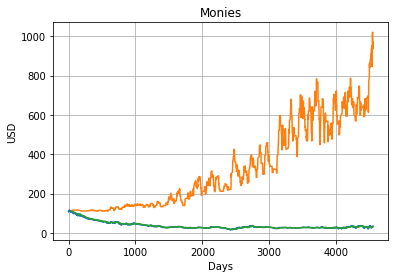

In [101]:
fig, ax = plt.subplots()
ax.plot(range(4551), data["Price"])
ax.plot(range(4551), agent.MovingAverages(agent.portfolio))
ax.plot(range(4551), agent.moving_avg)

ax.set(xlabel='Days', ylabel='USD',
       title='Monies')
ax.grid()
plt.show()

# Bollinger Bands

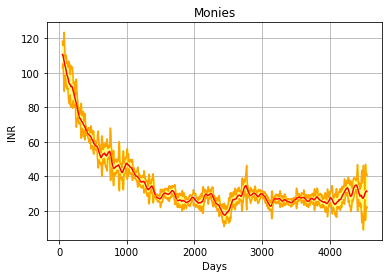

In [102]:
fig, ax = plt.subplots()
ax.plot(range(agent.length), agent.moving_avg+agent.Volatility(window_size=20), color='orange')
ax.plot(range(agent.length), agent.moving_avg, color='red')
ax.plot(range(agent.length), agent.moving_avg-agent.Volatility(window_size=20), color='orange')

ax.fill_between(range(agent.length), agent.moving_avg+agent.Volatility(window_size=20), 
                agent.moving_avg-agent.Volatility(window_size=20), color='yellow',
                alpha='0.5')

ax.set(xlabel='Days', ylabel='INR',
       title='Monies')
ax.grid()
plt.show()